# Semi-empirical rudder rudder with thrust
Using VCT data from *20211389_AWOceanbird* which contains thrust.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_simplified import vmm
#from vessel_manoeuvring_models.models.vmm_abkowitz_expanded import abkowitz_model_expanded as vmm

from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.regression import Regression
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.symbols import *
from vessel_manoeuvring_models.parameters import df_parameters
from vessel_manoeuvring_models.prime_system import PrimeSystem
from wPCC_pipeline.pipelines.vct_data.nodes import vct_scaling
p = df_parameters['symbol']
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.substitute_dynamic_symbols import lambdify, run
import statsmodels.api as sm
import seaborn as sns
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import *
import matplotlib.pyplot as plt
plt.style.use('bmh')
from copy import deepcopy
from symseaman.shipdict import ShipDict

#from vct.bokeh_plotting import create_tab

In [3]:
shipdict = ShipDict.load("HS5041-01.ship")

In [4]:
rudder_particulars_ = shipdict['rudder_particulars'][0]
prop_data_ = shipdict['fix_prop_data'][0]

In [5]:
df_VCT = pd.read_csv("HS5041-01.df_VCT_CT.csv", index_col=0)

In [6]:
df_VCT.head()

,index,Dp,S,S_Rudder,S_Rudder_top,S_Xgrid,V,beta,delta,fx,fx_Rudder,fx_Rudder_top,fx_Xgrid,fy,fy_Rudder,fy_Rudder_top,fy_Xgrid,fz,fz_Rudder,fz_Rudder_top,fz_Xgrid,g,lpp,mx,mx_Rudder,mx_Rudder_top,mx_Xgrid,my,my_Rudder,my_Rudder_top,my_Xgrid,mz,mz_Rudder,mz_Rudder_top,mz_Xgrid,r,result_file_path,rho,rn,roll,u,v,PROPLOG,rev,rev_p2609,thrust,thrust_p2609,torque,torque_p2609,name,path,p,phi,model_name,test type,eta0,fx_rudders,fy_rudders,fz_rudders,mx_rudders,my_rudders,mz_rudders,T_tot_net_force,method
0,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,7.3,8427.051918,85.703118,35.206243,8306.123723,6.687778,0.0,-0.069813,-695454.664812,-13235.807819,4081.883780,-686301.696892,-41199.939559,-34320.255798,-275.304998,-6604.327945,-6.469848e+06,145.458618,9965.414043,-6.479952e+06,9.80665,224.1,192545.345374,220188.387459,233.844023,-27877.138799,8.115905e+08,-1.179535e+05,-2.249092e+06,8.139570e+08,4.439464e+06,3.837301e+06,29512.302331,5.726573e+05,0.0,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,998.71,3929410.0,0.0,6.687778,-0.0,NaN,1.054798,0.0,0.0,0.0,0.0,0.0,hs5041-01_RA-04\v13.0mTd,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,0,0,HS5041-01,Rudder angle resistance (no propeller),1.0,-13235.807819,-34320.255798,145.458618,-133162.592497,51354.934340,3.845585e+06,0.0,virtual captive test
1,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,7.3,8427.051918,85.702275,35.206285,8306.123723,6.687778,0.0,0.069813,-695291.484470,-13254.967864,4075.956965,-686112.731422,43775.471729,34745.373337,329.258593,8700.883088,-6.468484e+06,167.640981,10014.115941,-6.478670e+06,9.80665,224.1,-190880.327514,-222300.211742,-250.861297,31670.695839,8.113483e+08,-1.231094e+05,-2.260003e+06,8.137330e+08,-4.695742e+06,-3.885269e+06,-35398.114964,-7.750553e+05,0.0,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,998.71,3929410.0,0.0,6.687778,-0.0,NaN,1.054798,0.0,0.0,0.0,0.0,0.0,hs5041-01_RA04\v13.0mTd,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,0,0,HS5041-01,Rudder angle resistance (no propeller),1.0,-13254.967864,34745.373337,167.640981,134812.048546,51429.275313,-3.893219e+06,0.0,virtual captive test
2,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,7.3,8427.051918,86.140903,35.204431,8305.702370,6.687778,0.0,0.139626,-699939.583332,-18287.321611,3984.600441,-685635.236005,86574.339793,71153.342426,1121.683034,14299.278196,-6.471464e+06,-3828.648970,9801.654007,-6.477445e+06,9.80665,224.1,-395504.469451,-454548.986558,-427.081546,59469.777093,8.120366e+08,7.449342e+05,-2.212360e+06,8.135010e+08,-9.336764e+06,-7.960274e+06,-123591.014534,-1.252926e+06,0.0,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,998.71,3929410.0,0.0,6.687778,-0.0,NaN,1.054798,0.0,0.0,0.0,0.0,0.0,hs5041-01_RA08\v13.0mTd,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,0,0,HS5041-01,Rudder angle resistance (no propeller),1.0,-18287.321611,71153.342426,-3828.648970,276074.968611,70954.807849,-7.972732e+06,0.0,virtual captive test
3,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,7.3,8427.051918,86.307338,35.203714,8305.533829,6.687778,0.0,0.174533,-703398.366648,-22271.688668,3942.819122,-685069.468870,105386.980894,90924.242484,1889.923848,12572.874978,-6.472038e+06,-6353.009704,9691.156260,-6.475375e+06,9.80665,224.1,-508334.302493,-578301.388488,-528.247144,70494.320813,8.122241e+08,1.288639e+06,-2.187504e+06,8.131219e+08,-1.144333e+07,-1.017645e+07,-209115.136066,-1.057755e+06,0.0,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,998.71,3929410.0,0.0,6.687778,-0.0,NaN,1.054798,0.0,0.0,0.0,0.0,0.0,hs5041-01_RA10\v13.0mTd,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,0,0,HS5041-01,Rudder angle resistance (no propeller),1.0,-22271.688668,90924.242484,-6353.009704,352786.060838,86414.152032,-1.018806e+07,0.0,virtual captive test
4,\\sspa.local\linux\lin-com\2021\20211389_AWOce...,7.3,8472.250647,85.571850,35.209064,8351.478714,4.115556,0.0,-0.069813,-285663.840033,-5175.798245,1249.205901,-281737.264170,-15194.229833,-11896.263252,-82.225204,-3215.7

In [7]:
df_VCT['test type'].unique()

array(['Rudder angle resistance (no propeller)', 'Rudder and drift angle',
       'Drift angle', 'Rudder angle', 'Thrust variation',
       'self propulsion'], dtype=object)

In [8]:
solution_lift[Y_R]

pi*A_R*C_L_tune*b_R**2*n_prop*rho*((V_x - r*y_R)**2 + (r*x_R + v)**2)*(-A_R*Abs(delta/delta_lim) + 2*A_R + b_R**2*Abs(delta/delta_lim)**2 - 4*b_R**2*Abs(delta/delta_lim) + 4*b_R**2)*sin(delta - kappa*atan((r*x_R + v)/(V_x - r*y_R)))/(2*A_R - b_R**2*Abs(delta/delta_lim) + 2*b_R**2)**2

In [9]:
df_rudder_no_thrust = df_VCT.groupby(by='test type').get_group('Rudder angle resistance (no propeller)')

In [10]:
prop_data_

OrderedDict([('dfix', 7.3),
             ('gearfix', 1.0),
             ('pdfix', 0.83),
             ('protfix', 1.0),
             ('tdffix', 0.185),
             ('wffix', 0.298),
             ('xxfix', -109.15),
             ('yyfix', 0.0),
             ('zzfix', -3.7)])

In [11]:
n_prop_ = len(shipdict['fix_prop_data'])
rudder_particulars = {
'x_R' : rudder_particulars_['xxrud'],
'y_R' : rudder_particulars_['yyrud'],
'z_R' : rudder_particulars_['zzrud'],
'A_R' : rudder_particulars_['ar'],
'b_R'  : rudder_particulars_['rh'],
'n_prop':n_prop_,
'c' : rudder_particulars_['ar']/rudder_particulars_['rh'],
'w_f': prop_data_['wffix'],
}

prop_data = {
'r_0': prop_data_['dfix']/2,
'x': prop_data_['xxfix'] - rudder_particulars_['xxrud'],
}

In [12]:
n_prop_

1

In [23]:
rudder_parameters = {
"C_L_tune" : 1.0,
"delta_lim": np.deg2rad(35),
"kappa": 0.5, # (Small value means much flow straightening)
"nu" : 1.18849E-06,
}

In [24]:
lambdas_no_propeller.keys()

dict_keys([C_L, L, Lambda, Lambda_g, V_R, V_xr, V_yr, V_zr, gamma, Y_R, V_x])

In [25]:
lambdas_no_propeller[C_L]

<function _lambdifygenerated(A_R, b_R, delta, delta_lim, kappa, r, u, v, w_f, x_R, y_R)>

In [26]:
prediction = df_rudder_no_thrust.copy()
prediction['fy_rudders'] = run(function=lambdas_no_propeller[Y_R], inputs=df_rudder_no_thrust, **rudder_particulars, **rudder_parameters)
prediction['C_L'] = run(function=lambdas_no_propeller[C_L], inputs=df_rudder_no_thrust, **rudder_particulars, **rudder_parameters)

prediction['V_x'] = run(function=lambdas_no_propeller[V_x], inputs=df_rudder_no_thrust, **rudder_particulars, **rudder_parameters)

prediction['V_xr'] = run(function=lambdas_no_propeller[V_xR], inputs=prediction, **rudder_particulars, **rudder_parameters)


In [27]:
prediction[['V','V_x']]

,V,V_x
0,6.687778,4.69482
1,6.687778,4.69482
2,6.687778,4.69482
3,6.687778,4.69482
4,4.115556,2.88912
5,4.115556,2.88912
6,4.115556,2.88912
7,4.115556,2.88912
8,4.115556,2.88912


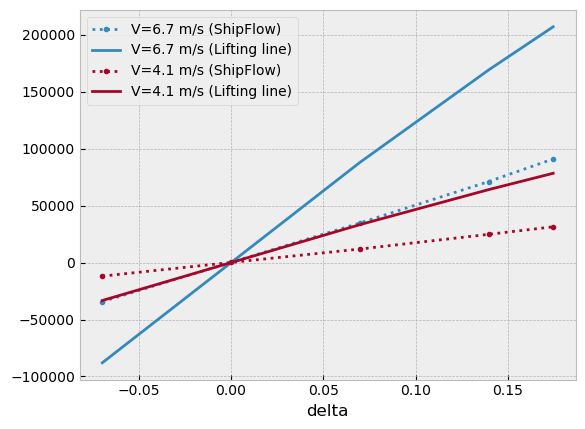

In [28]:
fig,ax=plt.subplots()
prediction_groups = prediction.groupby(by='V', sort=False)
key='fy_rudders'
for V_, group in df_rudder_no_thrust.groupby(by='V', sort=False):
    plot = group.plot(x='delta', y=key, label=f'V={np.round(V_,1)} m/s (ShipFlow)', style='.:', ax=ax)
    color = plot.lines[-1].get_color()
    prediction_groups.get_group(V_).plot(x='delta', y=key, label=f'V={np.round(V_,1)} m/s (Lifting line)', color=color, style='-', ax=ax)


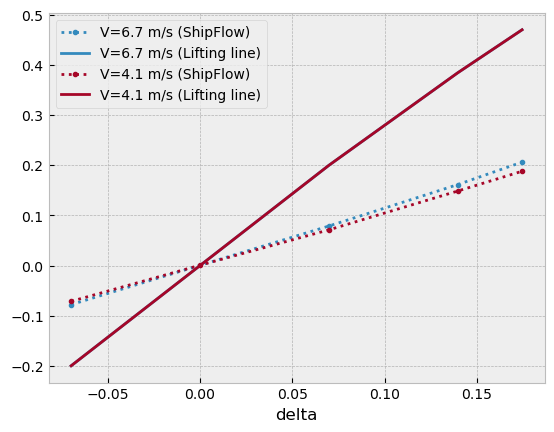

In [29]:
fig,ax=plt.subplots()
prediction_groups = prediction.groupby(by='V', sort=False)

rho_=1000
Ar_ = shipdict.rudder_particulars[0]['ar']
V_ = df_rudder_no_thrust['V']*(1-rudder_particulars['w_f'])
df_rudder_no_thrust['C_L'] = df_rudder_no_thrust['fy_rudders']/(1/2*rho_*Ar_*V_**2)

key='C_L'
for V_, group in df_rudder_no_thrust.groupby(by='V', sort=False):
    plot = group.plot(x='delta', y=key, label=f'V={np.round(V_,1)} m/s (ShipFlow)', style='.:', ax=ax)
    color = plot.lines[-1].get_color()
    prediction_groups.get_group(V_).plot(x='delta', y=key, label=f'V={np.round(V_,1)} m/s (Lifting line)', color=color, style='-', ax=ax)



Poor agreement, but the ShipFlow results are actually quite questionable here.

In [20]:
df_rudder = df_VCT.groupby(by='test type').get_group('Rudder angle')

In [30]:
df_rudder['T'] = df_rudder['thrust']
prediction_rudder_angle = df_rudder.copy()
d_delta=np.deg2rad(-2.1)
prediction_rudder_angle['delta_true'] = prediction_rudder_angle['delta'].copy()
prediction_rudder_angle['delta']+=d_delta
prediction_rudder_angle['V_x'] = run(function=lambdas_propeller[V_x], inputs=prediction_rudder_angle, **rudder_particulars, **rudder_parameters, **prop_data)
prediction_rudder_angle['fy_rudders'] = run(function=lambdas_lift[Y_R], inputs=prediction_rudder_angle, **rudder_particulars, **rudder_parameters)


In [31]:
prediction_rudder_angle['V_A'] = prediction_rudder_angle['V']*(1-rudder_particulars['w_f'])
prediction_rudder_angle[['V_x','V','V_A']]

,V_x,V,V_A
21,4.937026,6.687778,4.69482
22,4.936852,6.687778,4.69482
23,4.938868,6.687778,4.69482
24,4.944610,6.687778,4.69482
25,4.949248,6.687778,4.69482
26,3.038121,4.115556,2.88912
27,3.037294,4.115556,2.88912
28,3.038067,4.115556,2.88912
29,3.041818,4.115556,2.88912
30,3.044585,4.115556,2.88912


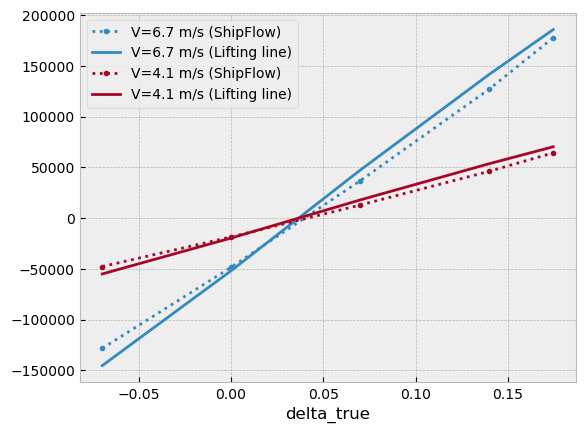

In [33]:
fig,ax=plt.subplots()
prediction_groups = prediction_rudder_angle.groupby(by='V', sort=False)
key='fy_rudders'
df_rudder_ = df_rudder.copy()
#d_delta=np.deg2rad(-2.4)
#df_rudder_['delta']+=d_delta

for V_, group in df_rudder_.groupby(by='V', sort=False):
    plot = group.plot(x='delta', y=key, label=f'V={np.round(V_,1)} m/s (ShipFlow)', style='.:', ax=ax)
    color = plot.lines[-1].get_color()
    prediction_groups.get_group(V_).plot(x='delta_true', y=key, label=f'V={np.round(V_,1)} m/s (Lifting line)', color=color, style='-', ax=ax)
fig.savefig("summaries/lifting_line.png")

Behind a working propeller the agreement is much better.

In [ ]:
df_thrust_variation = df_VCT.groupby(by='test type').get_group('Thrust variation')
assert len(df_thrust_variation) > 0
df_thrust_variation.sort_values(by=['V','delta','thrust'], inplace=True)

In [ ]:
prediction_thrust_variation= df_thrust_variation.copy()
prediction_thrust_variation['T'] = prediction_thrust_variation['thrust']
prediction_thrust_variation['V_x'] = run(function=lambdas_propeller[V_x], inputs=prediction_thrust_variation, **rudder_particulars, **rudder_parameters, **prop_data)
prediction_thrust_variation['fy_rudders'] = run(function=lambdas_lift[Y_R], inputs=prediction_thrust_variation, **rudder_particulars, **rudder_parameters)


In [ ]:
fig,ax=plt.subplots()
prediction_groups = prediction_thrust_variation.groupby(by=['V','delta'], sort=False)
key='fy_rudders'

for V_, group in df_thrust_variation.groupby(by=['V','delta'], sort=False):
    plot = group.plot(x='thrust', y=key, label=f'V={np.round(V_,1)} m/s (ShipFlow)', style='.:', ax=ax)
    color = plot.lines[-1].get_color()
    prediction_groups.get_group(V_).plot(x='thrust', y=key, label=f'V={np.round(V_,1)} m/s (Lifting line)', color=color, style='-', ax=ax)
